### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import scipy
import emcee 

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

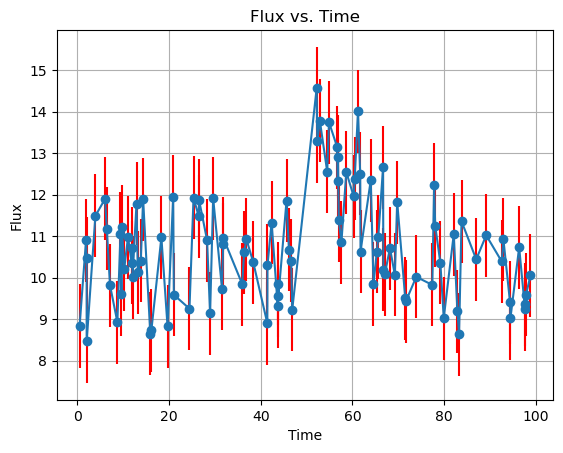

In [2]:
file = np.load('hw_data_cp/hw5_data_1.npy')
time = file[:,0] # Time arb units 
flux = file[:,1] # Flux arb units 
fnoise = file[:,2] # Homoescedastic measurement uncertainties on the flux
del file

plt.errorbar(x=time,y=flux,yerr=fnoise,ecolor='red',marker='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux vs. Time')
plt.grid();

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

Optimization terminated successfully.
         Current function value: 17.146752
         Iterations: 182
         Function evaluations: 313

Amplitude fit:  6.664917893701345 
Burst die off fit:  0.11890570580257258 
Intercept value fit:  10.28787543355292 
Burst epoch fit:  47.46226996033769 



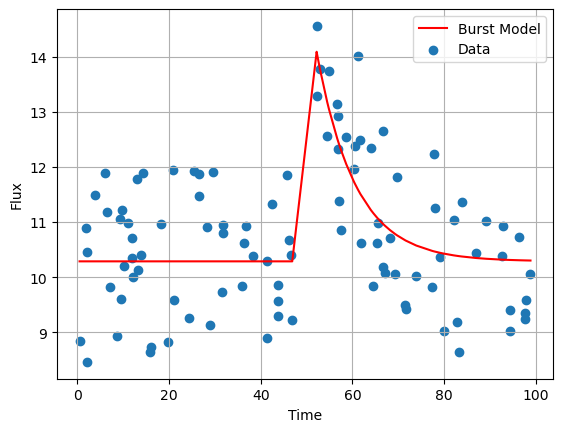

In [3]:
def burst_model(finput,time): #Burst model
    A = finput[0] #Amplitude
    c = finput[1] #Burst die off rate
    b = finput[2] #Background Amplitude 
    t0 = finput[3] #Burst Epoch
    model = []
    for t in time:
        if t >= t0:
            model.append(A * np.exp(- c * (t-t0)) + b)
        else:
            model.append(b) 
    return np.array(model) #Numpy arrays are best
    
def L(finput, time, flux, fnoise):
    func = burst_model(finput,time) # Grabs model with parameters 
    chi2 = (np.sqrt(2*np.pi*fnoise**2))**(-1) * ((flux - func) / fnoise)**2 # chi^2 
    Likelihood = np.exp(chi2 / 2) # Liklihood function 
    return np.prod(Likelihood) # Multiply all liklihoods

def prior(finput):
    return 1.0 / 10 
    
def posterior(finput, time, flux, fnoise):
    return L(finput, time, flux, fnoise) * prior(finput) # posterior

def log_L(finput, time, flux, fnoise):
    return np.log(posterior(finput, time, flux, fnoise)) #log posterior

fitf = lambda beta: log_L(finput=beta,
                      time=time,
                      flux=flux,
                      fnoise=fnoise)

# beta0 = (8, # Amplitude
#          8e-2, # Burst die off rate
#          9.45, # Background Amplitude
#          40) # Burst Epoch

beta0 = (5, # Amplitude
         0.8, # Burst die off rate
         10, # Background Amplitude
         45) # Burst Epoch

beta_squared = scipy.optimize.fmin(fitf,beta0)

print('\nAmplitude fit: ', beta_squared[0],
     '\nBurst die off fit: ',beta_squared[1],
     '\nIntercept value fit: ', beta_squared[2],
      '\nBurst epoch fit: ', beta_squared[3],'\n')

fit_func = burst_model(beta_squared,time)

plt.plot(time, fit_func,color='red',label='Burst Model')
plt.scatter(time,flux,label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.grid();

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,5]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/j3/1wfcykhx07bcnpbjshp_sztr0000gp/T/ipykernel_80545/2902739293.py:23: RuntimeWarning: overflow encountered in exp
  Likelihood = np.exp(chi2 / 2)


done
A mean:  5.857217769399471 
c_mean:  0.12092715789518878 
b_mean:  10.751434504658047 
t0_mean:  51.5140739663861


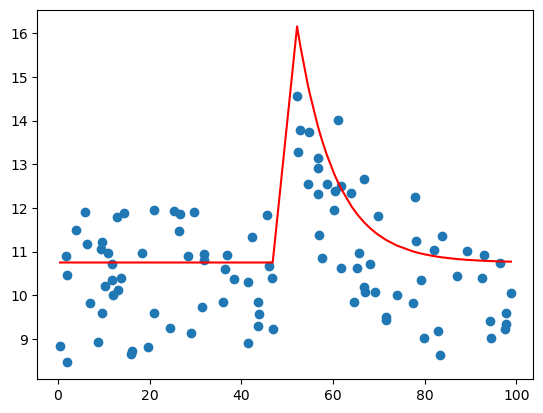

In [4]:
def burst_model(finput,time): #Burst model
    A = finput[0] #Amplitude
    c = finput[1] #Burst die off rate
    b = finput[2] #Background Amplitude 
    t0 = finput[3] #Burst Epoch
    model = []
    for t in time:
        if t >= t0:
            model.append(A * np.exp(- c * (t-t0)) + b)
        else:
            model.append(b) 
    return np.array(model) #Numpy arrays are best
    
def prior(finput):
    if (0<=finput[0]<=50) and (np.exp(-5)<=finput[1]<=np.exp(5)) and (0<=finput[2]<=50) and (0<=finput[3]<=100):
        return 1 
    else: 
        return 2
        
def L(finput, time, flux, fnoise):
    func = burst_model(finput,time)
    chi2 = (np.sqrt(2*np.pi*fnoise**2))**(-1) * ((flux - func) / fnoise)**2
    Likelihood = np.exp(chi2 / 2)
    return np.prod(Likelihood)

def posterior(finput, time, flux, fnoise):
    if prior(finput) == 2: #if prior not followed make likihoosd zero (ln(1) = 0)
        return 1 / 10
    else:
        return L(finput, time, flux, fnoise) * prior(finput)
        
def lnL(finput, time, flux, fnoise):
    return np.log(posterior(finput, time, flux, fnoise))
    
def emcee_fit(ndim,nwalkers,burn,nsteps,lnL):
    #Param initial guesses 
    A_guess = np.random.uniform(3.5,5,nwalkers)
    c_guess = np.random.uniform(0.1,0.12,nwalkers)
    b_guess = np.random.uniform(9.5,11,nwalkers)
    t0_guess = np.random.uniform(50,52,nwalkers) 
    ######
    starting_guess = np.column_stack([A_guess,c_guess,b_guess,t0_guess])
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnL,args=[time,flux,fnoise])
    sampler.run_mcmc(starting_guess, nsteps)
    emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim) #flatten and trim data
    print('done')
    return emcee_trace

ndim = 4
nwalkers = 600
burn = 300
nsteps = 2001
trace = emcee_fit(ndim,nwalkers,burn,nsteps,lnL)

#Burn done in 3 (check emcee function)
A_mean = trace[:,0].mean()
c_mean = trace[:,1].mean()
b_mean = trace[:,2].mean()
t0_mean = trace[:,3].mean()
mcmcfit = np.array([A_mean, c_mean, b_mean, t0_mean])

print("A mean: ", A_mean, '\nc_mean: ', c_mean, '\nb_mean: ', b_mean,'\nt0_mean: ', t0_mean)
y_mcmcfit = burst_model(mcmcfit,time)
plt.plot(time, y_mcmcfit,c='r')
plt.scatter(time, flux);

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

A mean:  6.033494857218671 
c_mean:  0.12040976491410148 
b_mean:  10.979836262627893 
t0_mean:  51.752206330699885


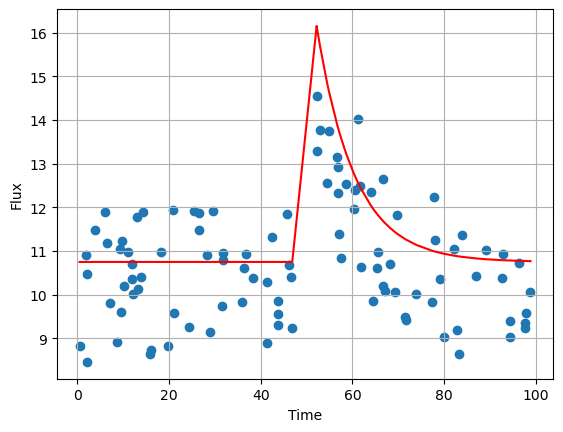

In [6]:
import acor
# Burn done in 3 (check emcee function)
l0 = int(np.round(acor.acor(trace[:,0])[0],0)) # Amplitude Auto Correlation Length (ACL)
l1 = int(np.round(acor.acor(trace[:,1])[0],0)) # Drop off rate ACL
l2 = int(np.round(acor.acor(trace[:,2])[0],0)) # background amplitude ACL
l3 = int(np.round(acor.acor(trace[:,3])[0],0)) # epoch ACL

#Get only ACL index of parameters
A = trace[:,0][::l0]
c = trace[:,1][::l1]
b = trace[:,2][::l2]
t0 = trace[:,3][::l3]

#Make all parameters at the same length, think of it as extra burn in 
lengths = np.array([A.shape,c.shape,b.shape,t0.shape])
lmin = lengths.min()
A = A[-lmin:]
c = c[-lmin:]
b = b[-lmin:]
t0 = t0[-lmin:]

# Plot just to test consistency
A_mean = A.mean()
c_mean = c.mean()
b_mean = b.mean()
t0_mean = t0.mean()

print("A mean: ", A_mean, '\nc_mean: ', c_mean, '\nb_mean: ', b_mean,'\nt0_mean: ', t0_mean)
y_mcmcfit = burst_model(mcmcfit,time)
plt.plot(time, y_mcmcfit,c='r');
plt.grid()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.scatter(time, flux);

In [7]:
lengths

array([[832],
       [671],
       [444],
       [714]])

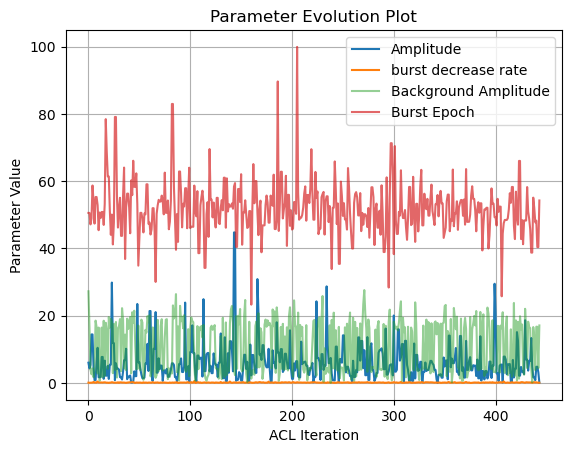

In [8]:
plt.plot(A, label='Amplitude')
plt.plot(c, label='burst decrease rate')
plt.plot(b, label = 'Background Amplitude',alpha=0.5)
plt.plot(t0, label = 'Burst Epoch',alpha=0.7)
plt.grid()
plt.ylabel('Parameter Value')
plt.xlabel('ACL Iteration')
plt.title('Parameter Evolution Plot')
plt.legend();
# ACL == Auto-correlation length 

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

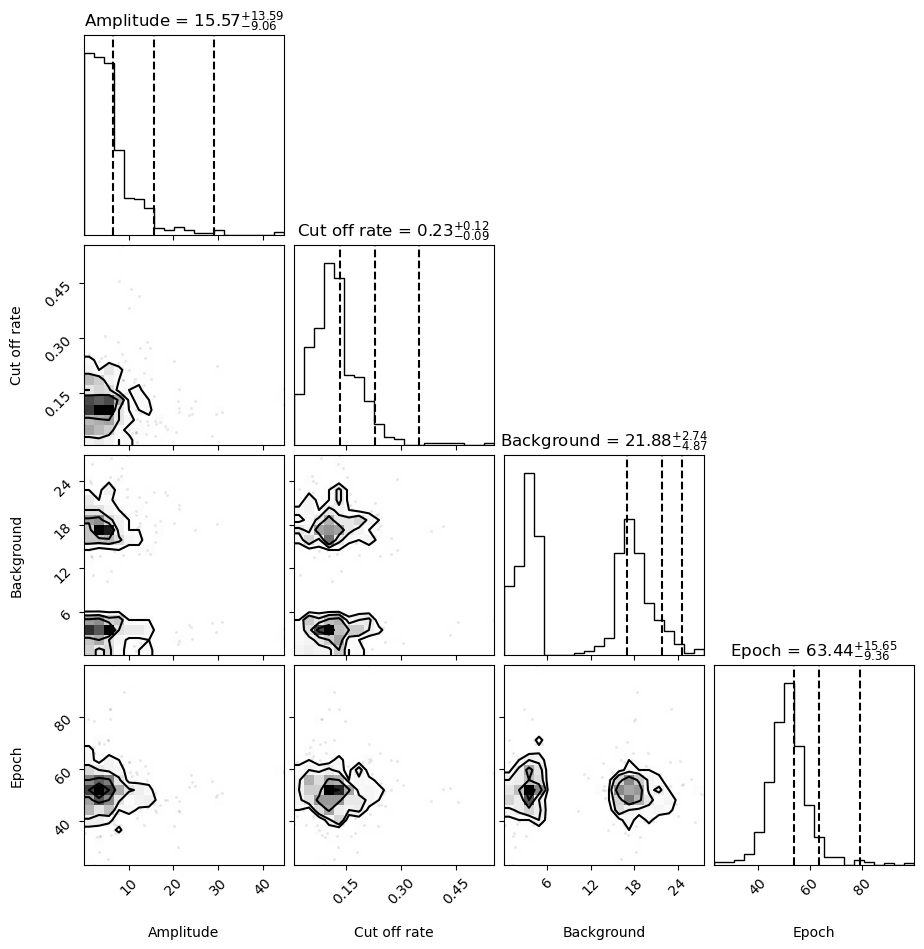

In [9]:
import corner

fit_vals = np.column_stack([A, c, b, t0])
Arr = np.reshape(fit_vals,(len(A),4))

figure = corner.corner(
    Arr,
    labels = ['Amplitude','Cut off rate', 'Background', 'Epoch'],
    quantiles=[0.68, 0.95,0.99],
    show_titles=True)

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

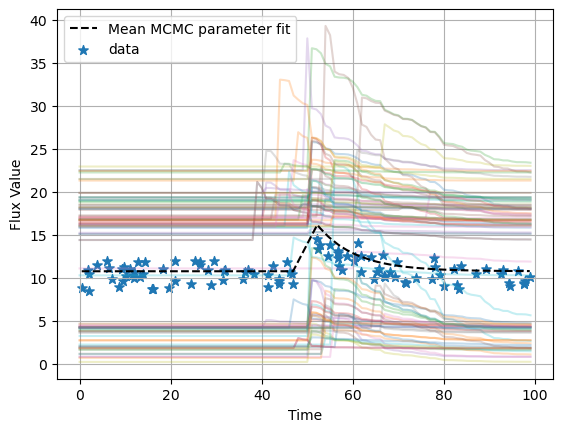

In [10]:
np.random.seed(42069)
inds = np.random.randint(0,len(A),100) # 100 random indices 
for params in fit_vals[inds]:
    plt.plot(burst_model(params,time),alpha=0.25)
plt.plot(time,y_mcmcfit,c='black',ls='--',label='Mean MCMC parameter fit')
plt.scatter(time,flux,s=50,marker='*',label='data')
plt.grid()
plt.ylabel('Flux Value')
plt.xlabel('Time')
plt.legend();
# This looks terrible, not sure if its my terrible work or the intended look.....

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [11]:
def gau_profile(pinput):
    A = pinput[0]
    b = pinput[1]
    t0 = pinput[2]
    sigma_w = pinput[3]
    model = []
    for t in time:
        if t >= t0:
            model.append(A * np.exp(- (t - t0)**2 / (2 * sigma_w**2)) + b)
        else:
            model.append(b)
    return np.array(model)

def prior(pinput):
    if (0<=pinput[0]<=50) and (0<=pinput[1]<=50) and (0<=pinput[2]<=100) and (np.exp(-2)<=pinput[3]<=np.exp(2)):
        return 1.0 / 10
    else:
        return 2
        
def posterior(pinput):
    if prior(pinput) == 2:
        return 1
    else:
        return like_f(pinput) * prior(pinput)

def logpost(pinput):
    return np.log(posterior(pinput))


def prior_t(pinput):
    params = pinput.copy()

    # transform amplitude parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = pinput[0] * (hi - lo) + lo

    # transform background amplitude parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = pinput[1] * (hi - lo) + lo

    # transform Epoch parameter: uniform prior
    lo = 0
    hi = 100
    params[2] = pinput[2] * (hi - lo) + lo

    # transform uncertainty parameter: uniform prior
    lo = np.exp(-2)
    hi = np.exp(2)
    params[3] = pinput[3] * (hi - lo) + lo

    return params

def like_f(pinput):
    model = gau_profile(pinput)
    like = -0.5 * (((model - flux)/fnoise)**2).sum()
    return like
    
# def my_likelihood(params):
#     location, amplitude, width = params
#     # compute intensity at every x position according to the model
#     y_model = amplitude * np.exp(-0.5 * ((x - location)/width)**2)
#     # compare model and data with gaussian likelihood:
#     like = -0.5 * (((y_model - y)/yerr)**2).sum()
#     return like

In [12]:
import ultranest

param_names = ['Amplitude', 'Background', 'Epoch', 'Uncertainty']

sampler = ultranest.ReactiveNestedSampler(param_names, like_f, prior_t)

In [13]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-48.9386..-48.9385]*| it/evals=7880/58208 eff=13.6313% N=400    0    
[ultranest] Likelihood function evaluations: 58240
[ultranest]   logZ = -63.99 +- 0.1515
[ultranest] Effective samples strategy satisfied (ESS = 2192.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -64.002 +- 0.406
  single instance: logZ = -64.002 +- 0.181
  bootstrapped   : logZ = -63.993 +- 0.405
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    Amplitude           : 1.55  │ ▁▁▁▁▁▁▂▄▅▆▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁▁ │7.40      3.64 +- 0.63
    Background          : 9.94  │ ▁▁▁▁▁▁▁▁▂▂▃▄▄▅▅▇▇▇▇▇▆▆▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁ │10.82     10.37 +- 0.11
    Epoch               : 46.6 

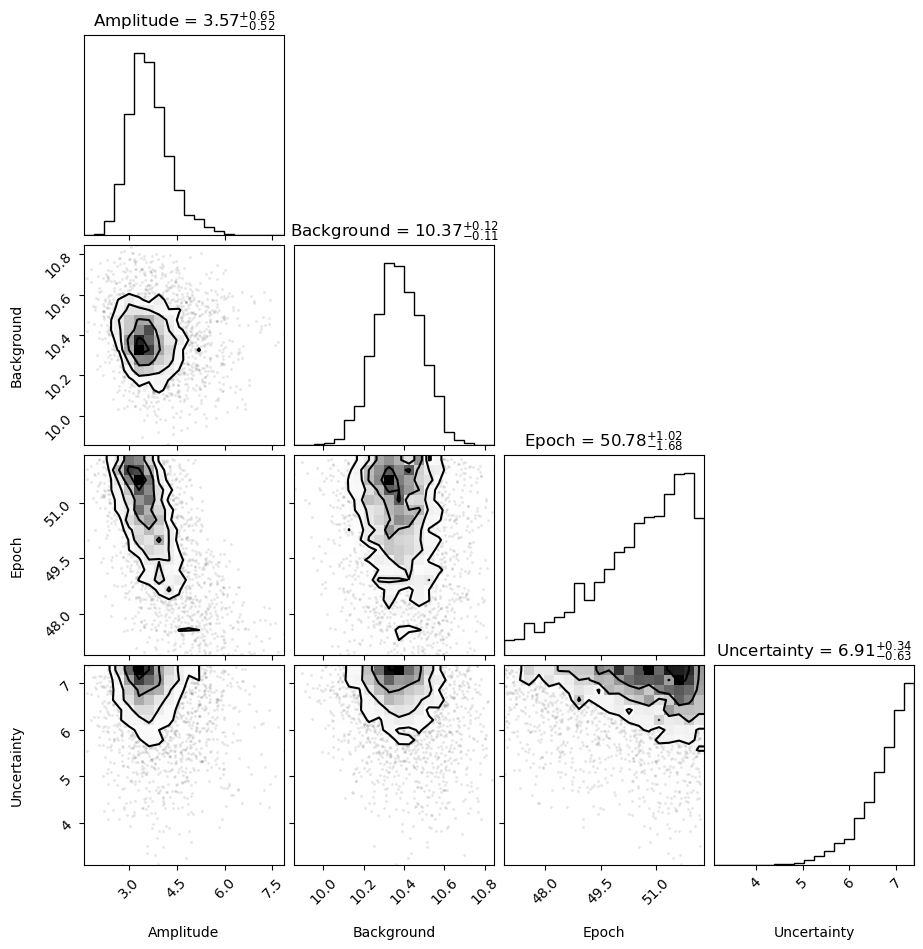

In [14]:
from ultranest.plot import cornerplot
cornerplot(result)

#How it should look! this is badass!!

# Amplitude 3.58 +/- 0.71
# Background 10.37 +/- 0.12
# Epoch 50.76 +/- 1.71

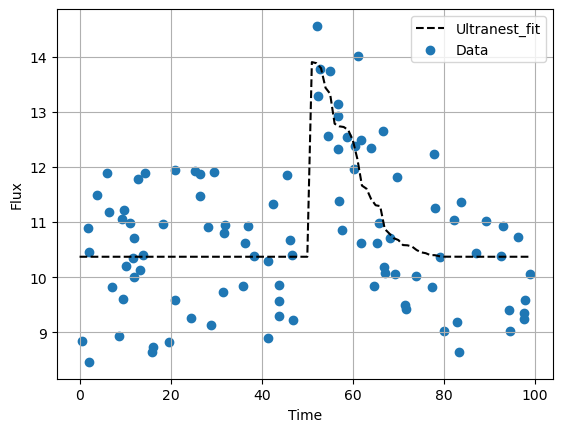

In [15]:
plt.plot(gau_profile(result['posterior']['mean']),c='black',ls='--',label='Ultranest_fit')
plt.scatter(time,flux,label='Data')
plt.grid()
plt.ylabel('Flux')
plt.xlabel('Time')
plt.legend();
#Very Beautiful 